In [ ]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import quiver

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

In [ ]:
import cv2
import os
import pickle
import math
import scipy
from scipy.spatial import Delaunay
math.pi

3.141592653589793

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import pims #  Python Image Sequence see https://github.com/soft-matter/pims                         
import trackpy as tp # Package for particle tracking in 2D, 3D, and higher dimensions
from skimage import util
from skimage.measure import label, regionprops

In [6]:
def convert_video_frames(analysisDir, videoDir, video_name):
    ''' Convert video to .tiff frames '''
    # Set Frames Folder
    framesDir = os.path.join(analysisDir, 'frames')

    # Verify if folder exists and is empty 
    convert = False
    if (not os.path.exists(framesDir)):
        print(f'Converting video {video_name} to frames ...')
        os.makedirs(framesDir)
        convert = True
    elif os.path.exists(framesDir) and os.listdir(framesDir) == []:
        convert = True

    # Convert video to frames if they do not exist
    if convert == True:
        # Open Video Capture
        videoStream = cv2.VideoCapture(videoDir)
        # Read Frame
        success, frame = videoStream.read()
        count = 0
        # Read Video
        while success:
            # Write Frame
            cv2.imwrite(os.path.join(framesDir, "frame_%d.tiff" % count), frame)  
            # Read Frame     
            success, frame = videoStream.read()
            count += 1
        print('Conversion completed!')
    else :
        print('Frames for this video already exist')

    return len([file for file in os.listdir(framesDir) if file.endswith('.tiff')])


def tiff_to_pkl(analysisDir):
    ''' Save raw image objects to pickle '''
    # Set Frames Folder and Pickle Path
    framesDir = os.path.join(analysisDir, 'frames')
    pklPath = os.path.join(analysisDir, 'rawFrames.pkl')
    
    # Save raw frames as pickle if they do not exist
    if not os.path.exists(pklPath):
        print('Saving raw frames as pickle ...')
        rawFrames = pims.open(os.path.join(framesDir, '*.tiff'))
        with open(pklPath, 'wb') as f:
            pickle.dump(rawFrames, f)
        print('Pickle saved!')
    return pklPath

def load_rawFrames(pklPath):
    ''' Load raw image objects from pickle '''
    with open(pklPath, 'rb') as f:
        rawFrames_loaded = pickle.load(f)
    return rawFrames_loaded

def video_time(videoDir, nFrames):
    ''' Get video time and fps '''
    # Open Video Capture
    videoStream = cv2.VideoCapture(videoDir)
    # Fps
    fps = videoStream.get(cv2.CAP_PROP_FPS)
    # Total Time
    tVideo = nFrames/fps
    return fps, tVideo


@pims.pipeline
def crop(img, df_row: pd.DataFrame):
    ''' Crop the image to select the region of interest '''
    x_min = df_row['x_min'].values[0]
    x_max = df_row['x_max'].values[0]
    y_min = df_row['y_min'].values[0]
    y_max = df_row['y_max'].values[0]
    return img[y_min:y_max, x_min:x_max]

@pims.pipeline
def preprocess(image, df_row: pd.DataFrame):
    ''' Apply image processing functions to return a binary image '''
    # Convert images to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Crop image
    image = crop(image, df_row)
    # Gaussian adaptive thresholding
    par1 = df_row['AdThrParam1'].values[0]
    par2 = df_row['AdThrParam2'].values[0]
    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,par1,par2)
    return image

In [7]:
def get_features_df(frames, features_path, trajectories_path, videoDir, df_row: pd.DataFrame):
    ''' Get dataframe with features for each detected landmark '''
    # Create empty dataframe to storage landmarck features
    video_features = pd.DataFrame()
   
    # Check if features dataframe already exists
    if os.path.exists(features_path):
        print("Features dataframe already exists.")
        # Read features dataframe
        video_features = pd.read_csv(features_path, sep=';')
    else:
        for num, img in enumerate(frames):
            # Create figure instance to save image plot
            height, width = img.shape[:2]
            white = util.dtype_limits(img)[1]
            label_image = label(img, background=white)
            # Find landmarks in each frame
            nParticles = 0
            for region in regionprops(label_image, intensity_image=img):
                # Everywhere in the image, skip small and large areas
                if region.area < df_row['min_area'].values[0] or region.area > df_row['max_area'].values[0]:
                    continue
                # On the top of the image, skip small area with a second threshold
                if region.centroid[0] < 1000 and region.area < 14:
                    continue
                # Ensure centroids are confined between 0.2-0.8 of the total height and width
                if not (df_row['min_height'].values[0] * height <= region.centroid[0] <= df_row['max_height'].values[0] * height and
                        df_row['min_width'].values[0] * width <= region.centroid[1] <= df_row['max_width'].values[0] * width):
                    continue
                # Ensure circularity for each landmarck
                if region.minor_axis_length/region.major_axis_length < df_row['axis_ratio'].values[0]:
                    continue
                # Store features which survived to the criterions
                nParticles += 1
                aux_row = [{'y': region.centroid[0],
                        'x': region.centroid[1],
                        'frame': num,
                        'video_path': videoDir,
                        },]
                video_features = pd.concat([video_features, pd.DataFrame(aux_row)], ignore_index=True)
        # Save features dataframe
        video_features.to_csv(features_path, sep=';')
        print("Obtained features dataframe.")

        
    # Get initial trajectories dataframe
    findLostParticles = False
    if os.path.exists(trajectories_path):
        print("Trajectories dataframe already exists.")
        # Read trajectories dataframe
        video_trajectories = pd.read_csv(trajectories_path, sep=';')
    else:
        # Link features to obtain trajectories
        video_trajectories = tp.link(video_features, search_range=50 , memory=1000)
        # Find frames with wrong number of particles
        wrong_frames = video_features['frame'].value_counts()
        wrong_frames = wrong_frames[wrong_frames != df_row['nParticles'].values[0]].index.tolist()
        print(f"{len(wrong_frames)} frames ({len(wrong_frames)/len(frames)*100:.1f}%) have the wrong number of particles (different than {df_row['nParticles'].values[0]})")
        # Activate flag to find lost particles if there are frames with wrong number of particles, else save dataframe
        if len(wrong_frames) > 0 :
            wrong_frames = sorted(wrong_frames)
            print(f"{wrong_frames} have the wrong number of particles")
            findLostParticles = True
        else: 
            video_trajectories.to_csv(trajectories_path, sep=';')
            print("Obtained trajectories dataframe.")

    return video_features, video_trajectories, findLostParticles


def find_lost_particles(t, nFrames, trajectories_path):
    ''' Find lost particles between frames '''
    # Initialize lists to store particles to append or remove
    particleRemove = []
    particleFill = []
    # Iterate over unique particles and decide to append or remove them
    print("Particles detected:")
    for iParticle in np.unique(t['particle'].values):
        # Get particle data
        tParticle = t[t['particle'] == iParticle]
        print(iParticle, len(tParticle['y'].values))
        # Append (>95% frames number) or remove particles
        if len(tParticle['y'].values) > 0.9*nFrames and len(tParticle['y'].values) != nFrames:
            particleFill.append(iParticle)
        elif len(tParticle['y'].values) < nFrames:
            particleRemove.append(iParticle)
    print(f"Particles to remove: {particleRemove}")
    print(f"Particles to keep: {particleFill}")
    
    # Remove Particles       
    for iParticle in particleRemove:
        t.drop(t[(t['particle'] == iParticle) ].index, inplace=True)
    # Fill Particles with previous or next frame data
    for iParticle in particleFill:
        # Frames where the particle exists
        framesParticle = t[t['particle'] == iParticle]["frame"].values 
        # Frames where the particle is missing
        missing = [x for x in range(nFrames) if x not in set(framesParticle)] 
        for iFrame in missing[::-1]: # Start iterating in the last missing frame
            # Fill with value from closest frame where particle exists
            closestFrame = min(framesParticle, key=lambda x:abs(x-iFrame))
            # Get row with particle info in the closest frame
            iFill = t[(t['particle'] == iParticle) & (t['frame'] == closestFrame) ].index 
            # Add a new row with the particle info in the missing frame
            row = t.loc[iFill[0]].copy()
            row['frame'] = iFrame
            # Add row to the end of the dataframe
            t = pd.concat([t, pd.DataFrame([row])], ignore_index=True)

    # Sort dataframe by frame and particle
    t = t.sort_values(by=['frame', 'particle']).reset_index(drop=True)
    t = t.astype({'particle': int})
    # Save trajectories dataframe to csv
    t.to_csv(trajectories_path, sep=';', index=False)

    # Print paticles list after fill/remove missing values
    print("Particles after fill/remove missing values:")
    for iParticle in np.unique(t['particle'].values):
        tParticle = t[t['particle'] == iParticle]
        print(int(iParticle), len(tParticle['y'].values))

    return t

In [20]:
def get_extreme_frame(subtrajectories_df: pd.DataFrame):
    ''' Get frame with maximum displacement from frame 0 '''
    # Get sorted list of particles
    particles = sorted(subtrajectories_df['particle'].unique())
    # Find Extreme Frame Based on Maximum Displacement from Frame 0 - first particle only
    ti = subtrajectories_df[subtrajectories_df['particle'] == particles[0]]
    # Get the initial position (frame 0)
    x0 = ti['x'].values[0]
    y0 = ti['y'].values[0]
    # Calculate the displacement (Euclidean distance) from frame 0 for each frame
    ti['displacement'] = np.sqrt((ti['x'].values - x0)**2 + (ti['y'].values - y0)**2)
    # Find the index of the frame with the maximum displacement
    maxDisp, iFramePressure = np.max(ti['displacement'].values), np.argmax(ti['displacement'].values)
    # Print results
    print(f"Maximum displacement: {maxDisp}")
    print(f"Frame with maximum displacement: {iFramePressure}")
    return maxDisp, iFramePressure

def plot_trajectories(subtrajectories_df: pd.DataFrame, frames, folderAnalysis, iFramePressure: int, videoName: str):
    ''' Plot trajectories in undeformed and deformed gel '''
    # Define color map for trajectories
    cmap = matplotlib.colormaps.get_cmap('jet')
    # Plot Trajectories in Undeformed and Deformed Gel
    for f in [0, iFramePressure]:
        # Get particles in frame f
        thresholds = sorted([elem for elem in subtrajectories_df[subtrajectories_df["frame"] == f]['particle'].values])
        colormap = cmap(np.linspace(0.1, 1.0, len(thresholds) + 1))
        fig, ax = plt.subplots(figsize=(8, 8))
        particleList = sorted(subtrajectories_df['particle'].unique())
        # Plot trajectories (loop required only to personalize color for each trajectory)
        for idParticle, particle in enumerate(particleList):
            subtrajectories_df_particle = subtrajectories_df[subtrajectories_df['particle'] == particle]
            tp.plot_traj(subtrajectories_df_particle, superimpose = frames[f], ax=ax, plot_style={'color': colormap[idParticle+1]})
        # Save figure in analysis folder
        fig.savefig(os.path.join(folderAnalysis, videoName + f'_trajs_f{f}.png'), dpi=300)
        plt.close(fig)
        print(f"Trajectories for frame {f} plotted.")

def plot_markers(df_trajectories: pd.DataFrame, frames, folderAnalysis, idFrame: list, videoName: str):
    ''' Plot markers in frames '''
    slitCategory = "particle"
    # Plot markers in frames
    for id in idFrame:
        # Plot markers with personalized color for each particle
        cmap = matplotlib.colormaps.get_cmap('jet')
        fig, ax = plt.subplots(figsize=(8, 8))
        thresholds = sorted([elem for elem in df_trajectories[df_trajectories["frame"] == id][slitCategory].values]) # threshold markers by particle_id
        tp.annotate(df_trajectories[df_trajectories["frame"] == id], frames[id], ax=ax,  split_category=slitCategory, split_thresh=thresholds, color= cmap(np.linspace(0.1, 1.0, len(thresholds)+1)))
        ax.set_xlabel('x [px]')
        ax.set_ylabel('y [px]')
        # Normalize & Apply ColorBar 
        norm = matplotlib.colors.Normalize(vmin=0.1*len(thresholds), vmax=1.0*len(thresholds)) 
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
        sm.set_array([]) 
        plt.colorbar(sm, ticks=np.linspace(1, len(thresholds), len(thresholds))) 
        # Save figure in analysis folder
        fig.savefig(os.path.join(folderAnalysis, videoName + f"_marks_f{id}.png"), dpi=300)
        plt.close(fig)

def get_triangles(subtrajectories_df: pd.DataFrame, frames, idFramePressure: int, folderAnalysis, video_name: str):
    ''' Find Delaunay triangles of dataframe subtrajectories '''
    for idFrame in [0, idFramePressure]:    
        # Extract points from dataframe, sort them by particle id
        points = subtrajectories_df[subtrajectories_df['frame'] == idFrame][['x', 'y', 'particle']].values
        points = points[points[:,2].argsort()][:,:2]
        # Compute Delaunay triangulation
        tri = Delaunay(points)
        if idFrame == 0:
            triangles = tri
        # Plot the points and the Delaunay triangulation in frame 0, above the frame
        plt.figure(figsize=(8, 8))
        plt.imshow(frames[idFrame])
        plt.triplot(points[:,0], points[:,1], tri.simplices)
        plt.plot(points[:,0], points[:,1], 'o')
        # Label each particle
        for idx, (x, y) in enumerate(tri.points):
           plt.text(x, y, f'{idx+1}', fontsize=12, ha='right', color='black')
        # Save figure in analysis folder
        plt.savefig(os.path.join(folderAnalysis, video_name + f'_tri_f{idFrame}.png'), dpi=300)
        plt.close()
    return triangles

In [21]:
def find_circle(img, circle_path):
    ''' Find the circular contour in the image '''
    # Convert to Grayscle Image 
    imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    # Filter Image
    imgGray = cv2.medianBlur(imgGray, 5)

    # Get Image Shape
    rows = imgGray.shape[0]
    # Define Parameters for Hough Circle Transform
    params1 = range(20, 240, 20) 
    params2 = range(20, 240, 20) 
    minRadius = [int((1/20)*imgGray.shape[0])] 
    maxRadius = [int(imgGray.shape[0]/4.5)]

    # Iterate over parameters to find the best circle
    maxRadDetected = 0
    imgCopy = img.copy()
    for p1 in params1:
        for p2 in params2:
            for minR in minRadius:
                for maxR in maxRadius:
                    # Find the variable circles with circle's center and radius 
                    circles = cv2.HoughCircles(imgGray, cv2.HOUGH_GRADIENT, 1, rows / 8,
                                                param1 = p1, param2 = p2,
                                                minRadius=minR, maxRadius=maxR)
                    if circles is not None:
                        # If HoughCircles finds only one circle
                        if circles.shape[1] == 1:
                            circles = np.uint16(np.around(circles))
                            for i in circles[0, :]:
                                # Circle center
                                center = (i[0], i[1])
                                # Circle radius
                                radius = i[2]
                                print(f'Radius: {radius}')
                                # Store the largest circle
                                if radius > maxRadDetected:  
                                    imgCopy = img.copy()
                                    mask = np.zeros_like(imgGray)
                                    cv2.circle(mask, center, radius, (255,0,0), -1)   
                                    maxRadDetected = radius
                                    cv2.circle(imgCopy, center, radius, (255,0,0), 2)

    # Extract Circular Contour
    if maxRadDetected > 0:
        # Create the mask and save the image only if a circle was detected
        cv2.imwrite(circle_path, imgCopy)
        # Display and save the image with the detected circle 
        plt.figure(figsize=(8, 8))
        plt.imshow(imgCopy)  
        plt.axis('off') 
        plt.title('Detected Circle') 
        plt.savefig(circle_path, bbox_inches='tight', pad_inches=0.1)  
        plt.close() 
        # Find the circular contour
        _,thresh = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)       
        # Perimeter of the circular contour
        perimeter = cv2.arcLength(contours[0][0], True)
    else: 
        perimeter = None

    return perimeter, cv2.bitwise_and(img,img, mask=mask), imgCopy

In [26]:
def distance_landmarks(xp1, yp1, xp2, yp2):
    ''' Compute the distance between two landmarks '''
    return ((xp1 - xp2)**2 + (yp1 - yp2)**2)**0.5, xp1-xp2, yp1-yp2

def compute_in_plane_strain(triangles, subtrajectories):
    ''' Compute the in-plane strain for each triangle '''

    # Create a dataframe to store the area and strain of each triangle
    dfTriangle = pd.DataFrame(columns=["triangule", "area", "frame", "strain", "strain_xx", "strain_yy"])

    # Get sorted list of particles
    particles_list = sorted(subtrajectories['particle'].unique())

    # Compute the area and strain for each triangle
    for iTriangle in triangles.simplices:
        # Get the particles that form the triangle
        l1, l2, l3 = iTriangle

        # Get the x and y coordinates of each particles
        l1x = subtrajectories[subtrajectories['particle'] == particles_list[l1]]['x'].values
        l1y = subtrajectories[subtrajectories['particle'] == particles_list[l1]]['y'].values
        l2x = subtrajectories[subtrajectories['particle'] == particles_list[l2]]['x'].values
        l2y = subtrajectories[subtrajectories['particle'] == particles_list[l2]]['y'].values
        l3x = subtrajectories[subtrajectories['particle'] == particles_list[l3]]['x'].values
        l3y = subtrajectories[subtrajectories['particle'] == particles_list[l3]]['y'].values
        # print(f'Triangle {iTriangle}, {l1x, l1y, l2x, l2y, l3x, l3y}')

        # Compute distances between landmarks and x and y components in frame 0
        L012, L012_x, L012_y = distance_landmarks(l1x[0], l1y[0], l2x[0], l2y[0])
        L013, L013_x, L013_y = distance_landmarks(l1x[0], l1y[0], l3x[0], l3y[0])
        L023, L023_x, L023_y = distance_landmarks(l2x[0], l2y[0], l3x[0], l3y[0])

        # Initialize arrays to store the strain components
        strain12 = np.zeros((len(l1x)))
        strain13 = np.zeros((len(l1x)))
        strain23 = np.zeros((len(l1x)))
        strain12_xx = np.zeros((len(l1x)))
        strain13_xx = np.zeros((len(l1x)))
        strain23_xx = np.zeros((len(l1x)))
        strain12_yy = np.zeros((len(l1x)))
        strain13_yy = np.zeros((len(l1x)))
        strain23_yy = np.zeros((len(l1x)))
        strain = np.zeros((len(l1x)))
        strain_xx = np.zeros((len(l1x)))
        strain_yy = np.zeros((len(l1x)))
        area = np.zeros((len(l1x)))

        # Compute the area and strain for each frame f
        for i in range(len(l1x) - 1):
            # Compute the distances between landmarks and x and y components in frame f
            LP12, LP12_x, LP12_y = distance_landmarks(l1x[i + 1], l1y[i + 1], l2x[i + 1], l2y[i + 1])
            LP13, LP13_x, LP13_y = distance_landmarks(l1x[i + 1], l1y[i + 1], l3x[i + 1], l3y[i + 1])
            LP23, LP23_x, LP23_y = distance_landmarks(l2x[i + 1], l2y[i + 1], l3x[i + 1], l3y[i + 1])
            # Compute the strain components
            strain12[i] = (LP12 - L012) / L012
            strain13[i] = (LP13 - L013) / L013
            strain23[i] = (LP23 - L023) / L023
            strain12_xx[i] = (LP12_x - L012_x) / L012_x
            strain13_xx[i] = (LP13_x - L013_x) / L013_x
            strain23_xx[i] = (LP23_x - L023_x) / L023_x
            strain12_yy[i] = (LP12_y - L012_y) / L012_y
            strain13_yy[i] = (LP13_y - L013_y) / L013_y
            strain23_yy[i] = (LP23_y - L023_y) / L023_y
            # Compute the average in-plane strain
            strain[i] = (strain12[i] + strain13[i] + strain23[i]) / 3
            strain_xx[i] = (strain12_xx[i] + strain13_xx[i] + strain23_xx[i]) / 3
            strain_yy[i] = (strain12_yy[i] + strain13_yy[i] + strain23_yy[i]) / 3
            # Compute the area of the triangle
            area[i] = 0.5 * abs(l1x[i + 1] * (l2y[i + 1] - l3y[i + 1]) + l2x[i + 1] * (l3y[i + 1] - l1y[i + 1]) + l3x[i + 1] * (l1y[i + 1] - l2y[i + 1]))

        # Smooth the strain and area data
        strainSmooth = scipy.signal.savgol_filter(strain, 150, 2, mode='nearest')
        strainSmooth_xx = scipy.signal.savgol_filter(strain_xx, 150, 2, mode='nearest')
        strainSmooth_yy = scipy.signal.savgol_filter(strain_yy, 150, 2, mode='nearest')
        areaSmooth = scipy.signal.savgol_filter(area, 150, 2, mode='nearest')

        # Store the area and strain data in the dataframe
        dfTriangle.loc[len(dfTriangle)] = {"triangule": iTriangle, "area": areaSmooth, "frame": range(len(l1x)), "strain": strainSmooth, "strain_xx": strainSmooth_xx, "strain_yy": strainSmooth_yy}

    return dfTriangle

def get_plots(df_triangles, tVideo, nFrames, folderName, videoName):
    ''' Save .csv file for area and strain of each triangle '''
    # Explode list quantities: area, frame, strain
    dfExplode = df_triangles.explode(['area','frame','strain','strain_xx','strain_yy'])

    # Insert time column
    dfExplode["time"] = (tVideo/nFrames) * dfExplode["frame"]
    # Reset dataframe index
    dfExplode = dfExplode.reset_index()
    dfExplode.to_csv(os.path.join( folderName, videoName + '_results.csv'), sep=';')

Video: static_50-mbar.mp4
Analysis saved in: c:\Users\mrcarvalho\Documents\MRC_Folder_Work\2021_PhD\scientific divulgation\Papers\2024-07_Paper - Stimulation Device - CyclicCell\paper_submission\supplementary information\landmarck_tracking\static_50-mbar_analysis
Frames for this video already exist
Raw frames saved in: c:\Users\mrcarvalho\Documents\MRC_Folder_Work\2021_PhD\scientific divulgation\Papers\2024-07_Paper - Stimulation Device - CyclicCell\paper_submission\supplementary information\landmarck_tracking\static_50-mbar_analysis\rawFrames.pkl
Number of Frames: 1325
FPS: 30.026355208382906
Video Time [s]: 44.1279
Preprocess parameters saved in: c:\Users\mrcarvalho\Documents\MRC_Folder_Work\2021_PhD\scientific divulgation\Papers\2024-07_Paper - Stimulation Device - CyclicCell\paper_submission\supplementary information\landmarck_tracking\static_50-mbar_analysis\preprocessParameters.pkl
Images preprocessing is completed.
Cropped and Thresholded Frame 0:
Features dataframe already exis

C:\Users\mrcarvalho\AppData\Local\Temp\ipykernel_19956\1782801737.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ti['displacement'] = np.sqrt((ti['x'].values - x0)**2 + (ti['y'].values - y0)**2)
C:\Users\mrcarvalho\AppData\Local\Temp\ipykernel_19956\1782801737.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(1, len(thresholds), len(thresholds)))


Trajectories for frame 0 plotted.
Trajectories for frame 1111 plotted.
Radius: 283
Radius: 283
Radius: 283
Radius: 283
Radius: 279
Radius: 277
Radius: 279
Radius: 184


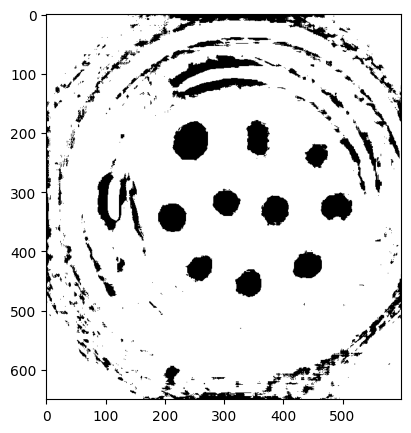

In [27]:
if __name__ == '__main__':
    features, trajectories = pd.DataFrame(), pd.DataFrame()
    rawFramesDict, framesDict = {}, {}
    dfExtremeFrame = pd.DataFrame(columns=['file', 'frame'])

    # Set video folder
    video = "static_50-mbar.mp4"
    video_name = video.split(".")[0]
    videoDir = os.path.join("video", video)
    print("Video:", video)
    # Create analysis folder
    analysisDir = os.path.join(os.getcwd(), video_name + "_analysis")
    if (not os.path.exists(analysisDir)):
        os.makedirs(analysisDir)
    print("Analysis saved in:", analysisDir)
    # Convert video to frames 
    nFrames = convert_video_frames(analysisDir, videoDir, video_name)
    # Save rawFrames as pickle
    rawFrames_pklPath = tiff_to_pkl(analysisDir)
    # Load pkl data
    rawFrames = load_rawFrames(rawFrames_pklPath)
    print("Raw frames saved in:", rawFrames_pklPath)
    # Get video info
    fps, tVideo = video_time(videoDir, nFrames)
    print(f"Number of Frames: {nFrames}")
    print("FPS:",fps)
    print("Video Time [s]:",tVideo)
    # Define parameters for preprocess raw frames 
    x_min = 50
    x_max = 650
    y_min = 350
    y_max = 1000
    AdThrParam1 = 71
    AdThrParam2 = 5
    min_area = 150
    max_area = 4500
    min_height = 0.15
    min_width = 0.25
    max_height = 0.75
    max_width = 0.95
    axis_ratio = 0.4
    nParticles = 10
    # Save preprocess parameters in .pkl file
    dfParams = pd.DataFrame([[video, x_min, x_max, y_min, y_max, AdThrParam1, AdThrParam2, min_area, max_area, min_height, min_width, max_height, max_width, axis_ratio, nParticles]], 
                            columns=['video_name', 'x_min', 'x_max', 'y_min', 'y_max', 'AdThrParam1', 'AdThrParam2', 'min_area', 'max_area', 'min_height', 'min_width', 'max_height', 'max_width', 'axis_ratio', 'nParticles'])
    params_pklPath = os.path.join(analysisDir, 'preprocessParameters.pkl')
    dfParams.to_pickle(params_pklPath)
    print("Preprocess parameters saved in:", params_pklPath)
    # Preprocess raw frames
    frames = preprocess(rawFrames, dfParams)
    print("Images preprocessing is completed.")
    # Verify if the image is correctly cropped and thresholded
    print("Cropped and Thresholded Frame 0:")
    plt.imshow(frames[0])
    # Find features in frames, get traectories and solve lost particles
    features_path = os.path.join(analysisDir, video_name + '_features.csv')
    trajectories_path = os.path.join(analysisDir, video_name + '_trajectories.csv')
    subfeatures, subtrajectories, findLostParticles = get_features_df(frames,
                                                                    features_path, trajectories_path, 
                                                                    videoDir, dfParams) 
    if findLostParticles:
        subtrajectories = find_lost_particles(subtrajectories, nFrames, trajectories_path)
    print("Features dataframe saved in:", features_path)
    print("Trajectories dataframe saved in:", trajectories_path)
    # Get extreme frame based on maximum displacement from frame 0
    maxDisp, iFramePressure = get_extreme_frame(subtrajectories)
    # Plot trajectories and markers in frames
    plot_markers(df_trajectories = subtrajectories, frames = crop(rawFrames, dfParams), folderAnalysis=analysisDir, 
                 idFrame = [0, iFramePressure], videoName= video_name)
    plot_trajectories(subtrajectories_df=subtrajectories, frames=crop(rawFrames, dfParams), 
                      folderAnalysis=analysisDir, iFramePressure=iFramePressure, videoName=video_name)
    # Find circular contour in the image
    circle_path = os.path.join(analysisDir, video_name + '_circle.png')
    pPix, imgMask, imgSegmented = find_circle(rawFrames[0], circle_path)
    # Get Delaunay triangles and compute in-plane strain
    triangles = get_triangles(subtrajectories, crop(rawFrames, dfParams), iFramePressure,folderAnalysis=analysisDir, video_name=video_name)
    df_triangles = compute_in_plane_strain(triangles, subtrajectories=subtrajectories)
    # Extract strain and area quantities from dataframe to csv
    results_path = os.path.join(analysisDir, video_name + '_results.csv')
    get_plots(df_triangles, tVideo, nFrames, analysisDir, video_name)

    
